In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [3]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [4]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [19]:
# specify data structure: null distribution (1), real distribution (2), or plot both (3)
get_null = 1
get_data = 1
classifierType = 2 # by TR or spatiotemporal
lowhigh = 0 # all TRs (0), low diff TRs (1), high diff TR
k1 = 0
k2 = 50
n_iter = 100
if lowhigh == 0:
    nTR = 450
if get_null:
    filename_null = 'new_bothphases/NULL_classifierType_' + str(classifierType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy'
    print(filename_null)
    all_file_names = glob.glob(filename_null)
    n_perm = len(all_file_names)
    print(n_perm)
    if classifierType == 1:
        null_avg_acc = np.zeros((nTR,n_iter,n_perm))
    elif classifierType == 2:
        null_acc = np.zeros((n_iter,n_perm))
    for f in np.arange(n_perm):
        z = np.load(all_file_names[f])
        if classifierType == 1:
            null_avg_acc[:,:,f] = z
        elif classifierType == 2:
            null_acc[:,f] = z
    
    if classifierType == 1:
        null_accuracy_dist = np.mean(null_avg_acc,axis=2).T

    if classifierType == 2:
        accuracy = np.mean(null_acc,axis=1)
        print('NULL average accuracy for spatiotemporal classifier is %4.4f +/- %4.4f' % (np.mean(accuracy),np.std(accuracy)))

if get_data:
    filename_data = 'new_bothphases/DATA_classifierType_' + str(classifierType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_0.npy'
    print(filename_data)
    if classifierType == 1:
        all_accuracies = np.load(filename_data) # this is in nTR x n_iter
        accuracy = all_accuracies.T # to be in n_iter x nTR
        nTR = np.shape(all_accuracies)[0]
        print('entire mean of TR data is %4.4f' % np.mean(accuracy))
    if classifierType == 2:
        accuracy = np.load(filename_data)
        print('DATA average accuracy for spatiotemporal classifier is %4.4f +/- %4.4f' % (np.mean(accuracy),np.std(accuracy)))

new_bothphases/NULL_classifierType_2_lowhigh_0_k1_0_k2_50_perm_*.npy
100
NULL average accuracy for spatiotemporal classifier is 0.4852 +/- 0.0288
new_bothphases/DATA_classifierType_2_lowhigh_0_k1_0_k2_50_perm_0.npy
DATA average accuracy for spatiotemporal classifier is 0.7800 +/- 0.2581


(447,)
(100, 447)


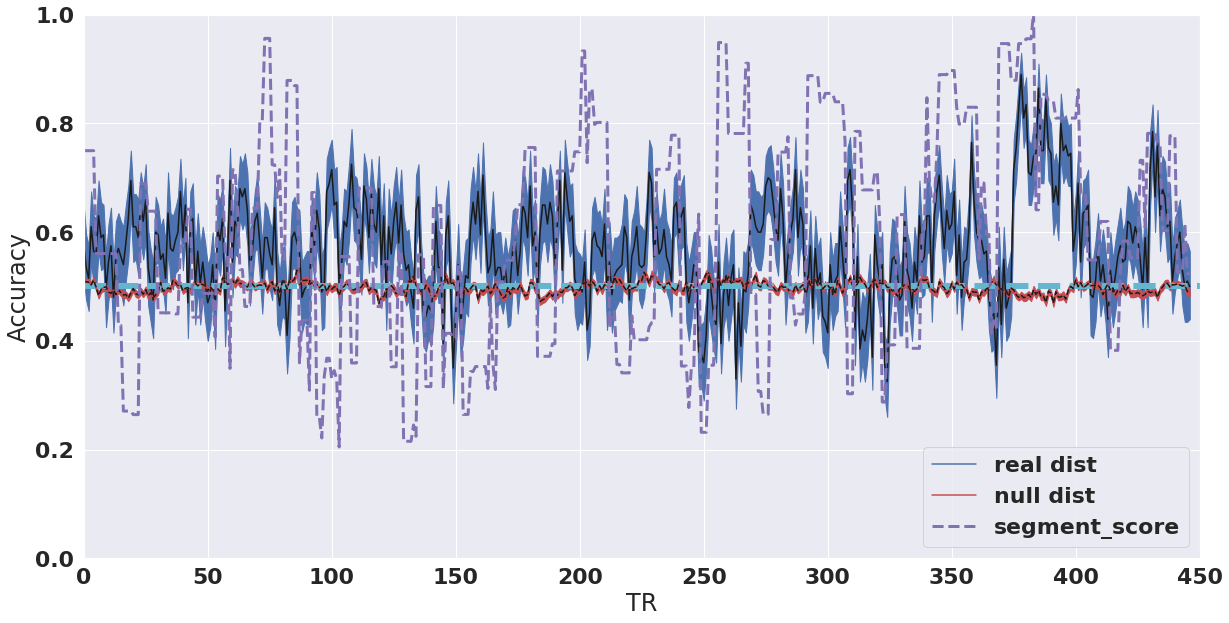

REAL correlation is 0.1308
REAL p value is 0.0056
NULL correlation is -0.0398
NULL p value is 0.4016


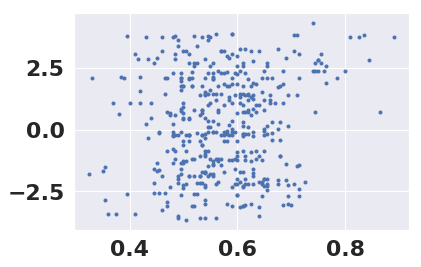

In [18]:
x = np.arange(nTR-3)
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
if get_null:
    err_y = null_accuracy_dist[:,3:]
    Edata = err_y.flatten()
    mean_err = np.mean(err_y,axis=0)
print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=100
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
if get_null == 0:
    matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
    df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])
elif get_null:
    matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],Edata[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
    df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','error','iter'])
sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1

plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')

plt.plot(x,np.mean(y,axis=0), color='k')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.5, .5], 'c--', lw=6)
plt.ylim([0,1])
plt.xlim([0,nTR])
if get_null:
    sns.lineplot(x="TR",y="error",color='r',data=df,ci=95,err_kws=err_band,label='null dist')
    plt.plot(x,np.mean(err_y,axis=0), '--k')
plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)
plt.plot()
plt.legend(loc=4)
plt.ylabel('Accuracy')
plt.show()
[corr,p] = scipy.stats.pearsonr(mean_acc,segment_score_vector[0:-3])
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %4.4f' % p)
if get_null:
    [corr,p] = scipy.stats.pearsonr(mean_err,segment_score_vector[0:-3])
    print('NULL correlation is %4.4f' % corr)
    print('NULL p value is %4.4f' % p)
plt.figure()
plt.plot(mean_acc,segment_score_vector[0:-3], '.')